In [1]:
# Cell 1: Mount Drive & Check GPU (run this first)
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

print("=" * 60)
print("SYSTEM CHECK")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU Device: {tf.config.list_physical_devices('GPU')[0].name}")
    print("✓ GPU is enabled - Training will be FAST!")
else:
    print("⚠ WARNING: No GPU detected!")
    print("Go to: Runtime > Change runtime type > Hardware accelerator > GPU")

print("=" * 60)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SYSTEM CHECK
TensorFlow version: 2.19.0
GPU Available: True
GPU Device: /physical_device:GPU:0
✓ GPU is enabled - Training will be FAST!


In [2]:
# Cell 2: Install Libraries (run once, then restart runtime)
print("Installing required libraries...")
print("=" * 60)

!pip install scikit-learn --upgrade -q
!pip install seaborn --upgrade -q

print("✓ All libraries installed successfully!")
print("=" * 60)
print("\n⚠️  IMPORTANT: Click 'Runtime → Restart runtime' now!")
print("   Then run cells starting from Cell 1 again")

Installing required libraries...
✓ All libraries installed successfully!

⚠️  IMPORTANT: Click 'Runtime → Restart runtime' now!
   Then run cells starting from Cell 1 again


In [3]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.optimizers import Adam

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# Utilities
import os
import json
from datetime import datetime
import warnings

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("=" * 60)
print("✓ All libraries imported successfully!")
print("=" * 60)
print(f"Random Seed: {SEED}")
print("Ready to start training!")

✓ All libraries imported successfully!
Random Seed: 42
Ready to start training!


In [4]:
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/Data'

# Data directories
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
VAL_DIR = os.path.join(BASE_PATH, 'val')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Output directories
PROJECT_ROOT = '/content/drive/MyDrive/Pneumonia_Project'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'Models', 'saved_models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'Models', 'results')
LOGS_DIR = os.path.join(PROJECT_ROOT, 'Models', 'logs')

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

print("=" * 60)
print("CHECKING FILE PATHS")
print("=" * 60)

# Verify data directories exist
paths_to_check = {
    'Training Data': TRAIN_DIR,
    'Validation Data': VAL_DIR,
    'Test Data': TEST_DIR
}

all_paths_valid = True

for name, path in paths_to_check.items():
    if os.path.exists(path):
        # Count images in this directory
        image_count = 0
        for root, dirs, files in os.walk(path):
            image_count += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        print(f"✓ {name}: {path}")
        print(f"  Images found: {image_count}")

        # Show subdirectories (should be NORMAL and PNEUMONIA)
        subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        print(f"  Classes: {subdirs}")

    else:
        print(f"✗ {name}: NOT FOUND - {path}")
        all_paths_valid = False

print("\n" + "=" * 60)
print("OUTPUT DIRECTORIES")
print("=" * 60)
print(f"✓ Models will be saved to: {MODELS_DIR}")
print(f"✓ Results will be saved to: {RESULTS_DIR}")
print(f"✓ Logs will be saved to: {LOGS_DIR}")

if not all_paths_valid:
    print("\n⚠ WARNING: Some paths are missing!")
    print("Please update BASE_PATH in this cell to match your Google Drive structure!")
else:
    print("\n✓ All paths verified - Ready to proceed!")
    print("=" * 60)

CHECKING FILE PATHS
✓ Training Data: /content/drive/MyDrive/Pneumonia_Project/Data/train
  Images found: 4119
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Validation Data: /content/drive/MyDrive/Pneumonia_Project/Data/val
  Images found: 883
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Test Data: /content/drive/MyDrive/Pneumonia_Project/Data/test
  Images found: 879
  Classes: ['NORMAL', 'PNEUMONIA']

OUTPUT DIRECTORIES
✓ Models will be saved to: /content/drive/MyDrive/Pneumonia_Project/Models/saved_models
✓ Results will be saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results
✓ Logs will be saved to: /content/drive/MyDrive/Pneumonia_Project/Models/logs

✓ All paths verified - Ready to proceed!


In [5]:
# MODEL CONFIGURATION

CONFIG = {
    # Model Architecture
    'model_name': 'DenseNet121',
    'img_size': 224,  # DenseNet121 input size (224x224)
    'img_channels': 3,  # RGB images

    # Training Parameters
    'batch_size': 32,  # Number of images per batch
    'epochs': 30,  # Maximum number of training epochs
    'learning_rate': 0.0001,  # Initial learning rate

    # Data Augmentation
    'rotation_range': 20,  # Degrees to randomly rotate images
    'width_shift_range': 0.2,  # Fraction of width to shift
    'height_shift_range': 0.2,  # Fraction of height to shift
    'zoom_range': 0.2,  # Range for random zoom
    'horizontal_flip': True,  # Randomly flip images horizontally

    # Regularization
    'dropout_rate': 0.5,  # Dropout rate to prevent overfitting

    # Early Stopping
    'patience_early_stop': 7,  # Stop if no improvement for 7 epochs
    'patience_lr_reduce': 3,  # Reduce LR if no improvement for 3 epochs

    # Class Names
    'class_names': ['NORMAL', 'PNEUMONIA'],

    # Random Seed
    'seed': SEED
}

# DISPLAY CONFIGURATION
print("=" * 60)
print("DENSENET121 CONFIGURATION")
print("=" * 60)
print("\n📐 Model Architecture:")
print(f"  Base Model: {CONFIG['model_name']}")
print(f"  Input Size: {CONFIG['img_size']}x{CONFIG['img_size']}x{CONFIG['img_channels']}")
print(f"  Classes: {CONFIG['class_names']}")

print("\n🎯 Training Parameters:")
print(f"  Batch Size: {CONFIG['batch_size']}")
print(f"  Max Epochs: {CONFIG['epochs']}")
print(f"  Learning Rate: {CONFIG['learning_rate']}")
print(f"  Dropout Rate: {CONFIG['dropout_rate']}")

print("\n🔄 Data Augmentation:")
print(f"  Rotation Range: ±{CONFIG['rotation_range']}°")
print(f"  Width Shift: {CONFIG['width_shift_range']}")
print(f"  Height Shift: {CONFIG['height_shift_range']}")
print(f"  Zoom Range: {CONFIG['zoom_range']}")
print(f"  Horizontal Flip: {CONFIG['horizontal_flip']}")

print("\n⏸️  Early Stopping:")
print(f"  Early Stop Patience: {CONFIG['patience_early_stop']} epochs")
print(f"  LR Reduce Patience: {CONFIG['patience_lr_reduce']} epochs")

print("\n🎲 Reproducibility:")
print(f"  Random Seed: {CONFIG['seed']}")

print("=" * 60)

# Save configuration to JSON file
config_path = os.path.join(RESULTS_DIR, 'densenet121_config.json')
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=4)
print(f"\n✓ Configuration saved to: {config_path}")

DENSENET121 CONFIGURATION

📐 Model Architecture:
  Base Model: DenseNet121
  Input Size: 224x224x3
  Classes: ['NORMAL', 'PNEUMONIA']

🎯 Training Parameters:
  Batch Size: 32
  Max Epochs: 30
  Learning Rate: 0.0001
  Dropout Rate: 0.5

🔄 Data Augmentation:
  Rotation Range: ±20°
  Width Shift: 0.2
  Height Shift: 0.2
  Zoom Range: 0.2
  Horizontal Flip: True

⏸️  Early Stopping:
  Early Stop Patience: 7 epochs
  LR Reduce Patience: 3 epochs

🎲 Reproducibility:
  Random Seed: 42

✓ Configuration saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results/densenet121_config.json


In [6]:
print("=" * 60)
print("SETTING UP DATA GENERATORS")
print("=" * 60)

# ============================================================
# TRAINING DATA AUGMENTATION
# ============================================================
print("\n1. Creating TRAINING generator with augmentation...")

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=CONFIG['rotation_range'],
    width_shift_range=CONFIG['width_shift_range'],
    height_shift_range=CONFIG['height_shift_range'],
    zoom_range=CONFIG['zoom_range'],
    horizontal_flip=CONFIG['horizontal_flip'],
    fill_mode='nearest',  # How to fill pixels after transformations
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(CONFIG['img_size'], CONFIG['img_size']),
    batch_size=CONFIG['batch_size'],
    class_mode='binary',  # Binary classification (0 or 1)
    shuffle=True,  # Shuffle data for better training
    seed=CONFIG['seed']
)

print(f"✓ Training generator created")
print(f"  Total samples: {train_generator.samples}")
print(f"  Batches per epoch: {len(train_generator)}")
print(f"  Class indices: {train_generator.class_indices}")
print(f"  Class distribution:", dict(zip(*np.unique(train_generator.classes, return_counts=True))))

# ============================================================
# VALIDATION DATA (NO AUGMENTATION)
# ============================================================
print("\n2. Creating VALIDATION generator (no augmentation)...")

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(CONFIG['img_size'], CONFIG['img_size']),
    batch_size=CONFIG['batch_size'],
    class_mode='binary',
    shuffle=False  # Don't shuffle validation data
)

print(f"✓ Validation generator created")
print(f"  Total samples: {val_generator.samples}")
print(f"  Batches: {len(val_generator)}")
print(f"  Class distribution:", dict(zip(*np.unique(val_generator.classes, return_counts=True))))

# ============================================================
# TEST DATA (NO AUGMENTATION)
# ============================================================
print("\n3. Creating TEST generator (no augmentation)...")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(CONFIG['img_size'], CONFIG['img_size']),
    batch_size=CONFIG['batch_size'],
    class_mode='binary',
    shuffle=False  # NEVER shuffle test data
)

print(f"✓ Test generator created")
print(f"  Total samples: {test_generator.samples}")
print(f"  Batches: {len(test_generator)}")
print(f"  Class distribution:", dict(zip(*np.unique(test_generator.classes, return_counts=True))))

print("\n" + "=" * 60)
print("✓ ALL DATA GENERATORS READY!")
print("=" * 60)

# Calculate class weights to handle imbalance
class_counts = dict(zip(*np.unique(train_generator.classes, return_counts=True)))
total = sum(class_counts.values())
class_weight = {
    0: total / (2 * class_counts[0]),  # Weight for NORMAL class
    1: total / (2 * class_counts[1])   # Weight for PNEUMONIA class
}

print(f"\n⚖️  Class weights (to handle imbalance):")
print(f"  NORMAL (0): {class_weight[0]:.3f}")
print(f"  PNEUMONIA (1): {class_weight[1]:.3f}")

SETTING UP DATA GENERATORS

1. Creating TRAINING generator with augmentation...
Found 4119 images belonging to 2 classes.
✓ Training generator created
  Total samples: 4119
  Batches per epoch: 129
  Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
  Class distribution: {0: 1114, 1: 3005}

2. Creating VALIDATION generator (no augmentation)...
Found 883 images belonging to 2 classes.
✓ Validation generator created
  Total samples: 883
  Batches: 28
  Class distribution: {0: 242, 1: 641}

3. Creating TEST generator (no augmentation)...
Found 879 images belonging to 2 classes.
✓ Test generator created
  Total samples: 879
  Batches: 28
  Class distribution: {0: 238, 1: 641}

✓ ALL DATA GENERATORS READY!

⚖️  Class weights (to handle imbalance):
  NORMAL (0): 1.849
  PNEUMONIA (1): 0.685


VISUALIZING SAMPLE IMAGES
✓ Sample images saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results/densenet121_sample_images.png


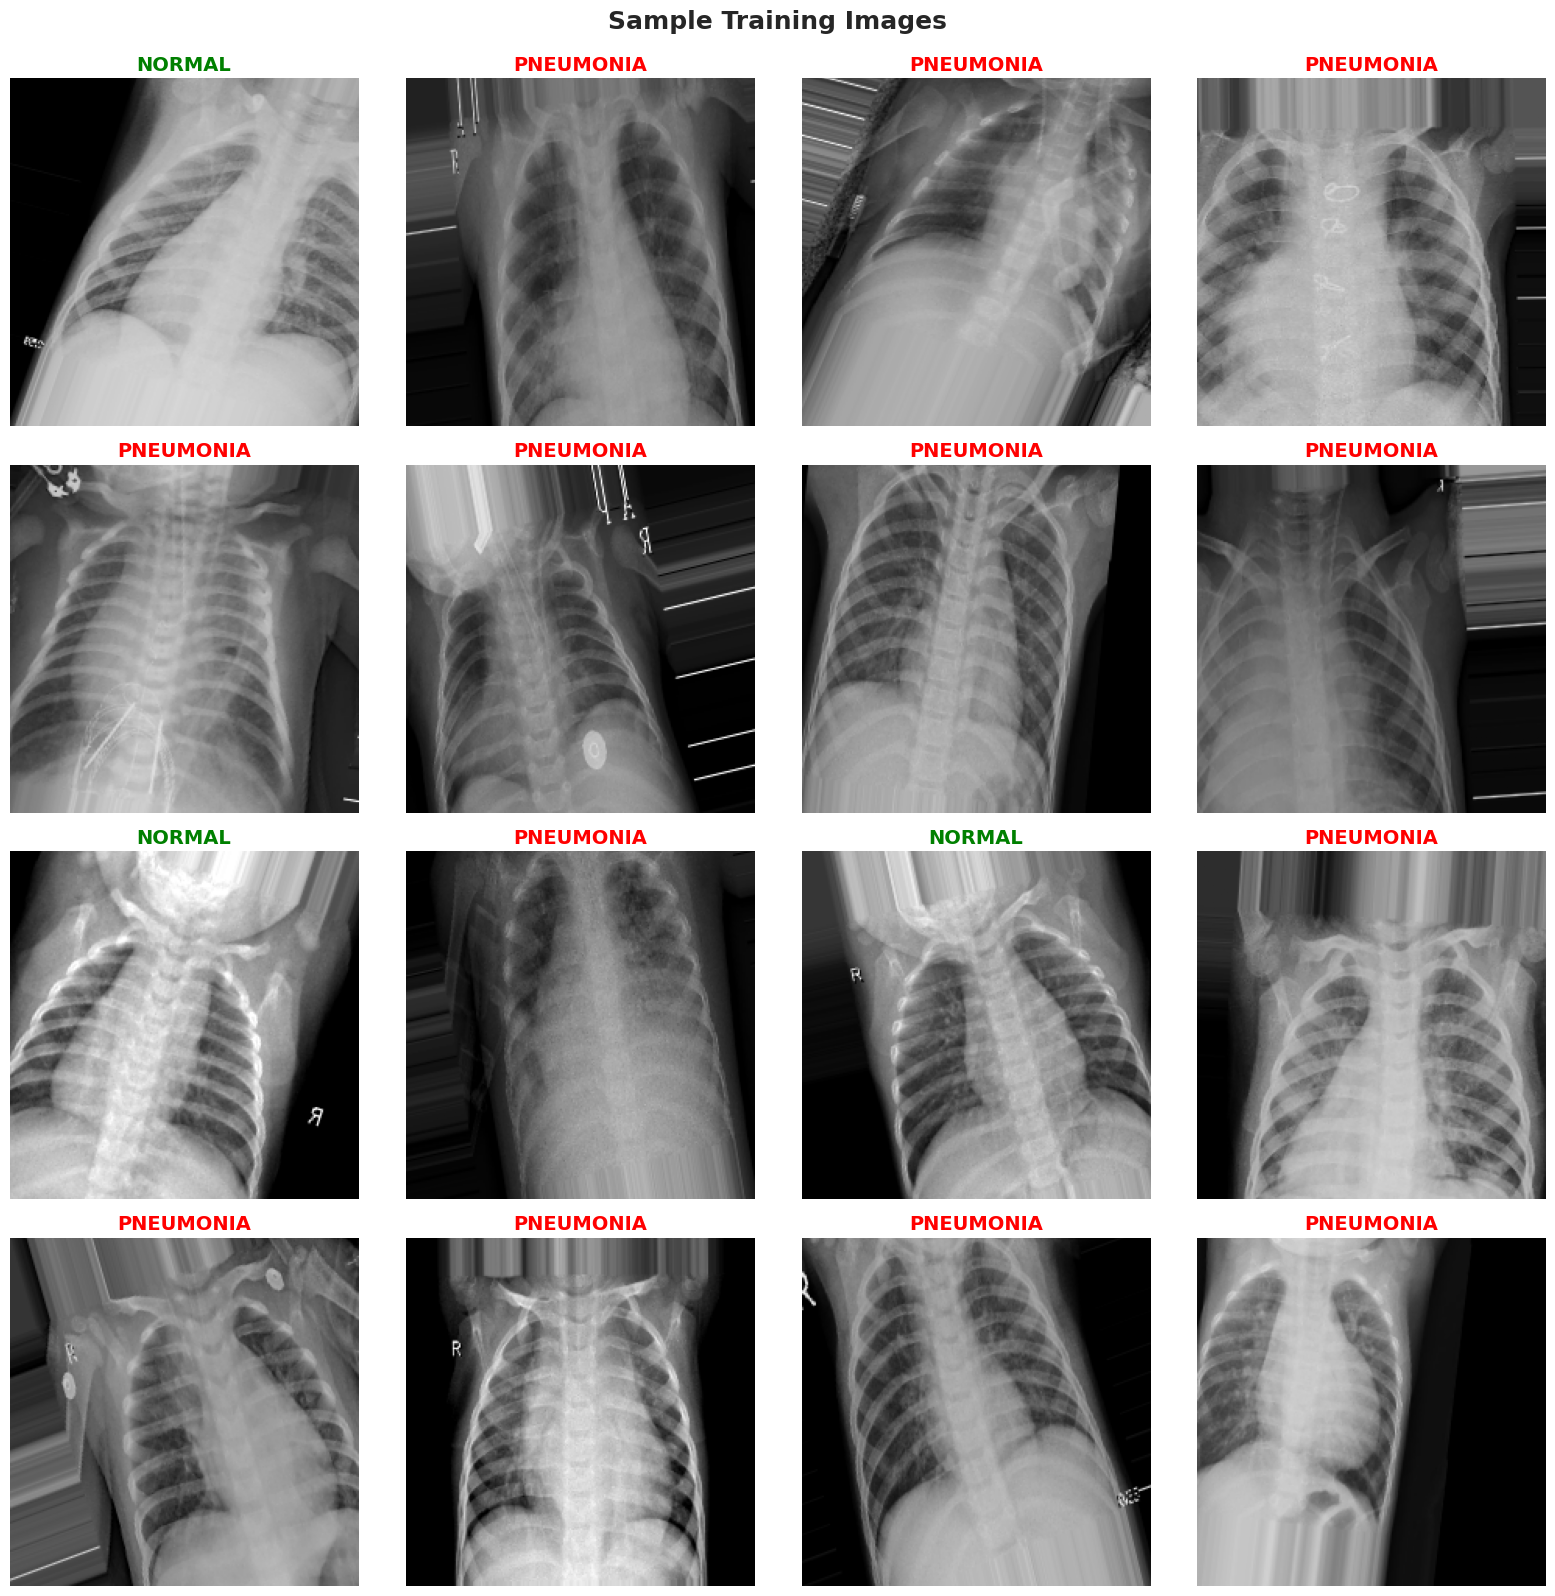


✓ If images look correct, proceed to model building!
  - Check that NORMAL images show clear lungs
  - Check that PNEUMONIA images show cloudy/white areas


In [7]:
def plot_sample_images(generator, num_images=16, save_path=None):
    """
    Display a grid of sample images from the generator

    Args:
        generator: ImageDataGenerator instance
        num_images: Number of images to display
        save_path: Path to save the figure
    """
    fig = plt.figure(figsize=(16, 16))

    # Get one batch of images
    images, labels = next(generator)

    # Plot images
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])

        # Get class name
        class_name = CONFIG['class_names'][int(labels[i])]

        # Set title with color based on class
        color = 'green' if class_name == 'NORMAL' else 'red'
        plt.title(f"{class_name}", fontsize=14, fontweight='bold', color=color)
        plt.axis('off')

    plt.suptitle('Sample Training Images', fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Sample images saved to: {save_path}")

    plt.show()

print("=" * 60)
print("VISUALIZING SAMPLE IMAGES")
print("=" * 60)

# Plot samples
sample_path = os.path.join(RESULTS_DIR, 'densenet121_sample_images.png')
plot_sample_images(train_generator, num_images=16, save_path=sample_path)

print("\n✓ If images look correct, proceed to model building!")
print("  - Check that NORMAL images show clear lungs")
print("  - Check that PNEUMONIA images show cloudy/white areas")

In [8]:
def build_densenet121_model(config):

    print("=" * 60)
    print("BUILDING DENSENET121 MODEL")
    print("=" * 60)

    # ============================================================
    # Load pre-trained DenseNet121
    # ============================================================
    print("\n1. Loading pre-trained DenseNet121 base...")

    base_model = DenseNet121(
        weights='imagenet',  # Use weights pre-trained on ImageNet
        include_top=False,  # Exclude final classification layer
        input_shape=(config['img_size'], config['img_size'], config['img_channels'])
    )

    print(f"   ✓ DenseNet121 base loaded")
    print(f"   Total layers in base: {len(base_model.layers)}")

    # ============================================================
    # Freeze base model weights
    # ============================================================
    print("\n2. Freezing base model weights...")

    base_model.trainable = False

    print(f"   ✓ Base model frozen (weights won't change during training)")

    # ============================================================
    # Build complete model
    # ============================================================
    print("\n3. Adding custom classification head...")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(name='global_avg_pool'),
        Dense(512, activation='relu', name='dense_512'),
        Dropout(config['dropout_rate'], name='dropout'),
        Dense(1, activation='sigmoid', name='output')
    ], name='DenseNet121_Pneumonia_Detector')

    print(f"   ✓ Custom layers added:")
    print(f"     - Global Average Pooling")
    print(f"     - Dense(512, relu)")
    print(f"     - Dropout({config['dropout_rate']})")
    print(f"     - Dense(1, sigmoid)")

    # ============================================================
    # Compile model
    # ============================================================
    print("\n4. Compiling model...")

    model.compile(
        optimizer=Adam(learning_rate=config['learning_rate']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),  # Recall = Sensitivity
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    print(f"   ✓ Model compiled with:")
    print(f"     - Optimizer: Adam (lr={config['learning_rate']})")
    print(f"     - Loss: Binary Crossentropy")
    print(f"     - Metrics: Accuracy, Precision, Recall, AUC")

    # ============================================================
    # Display model summary
    # ============================================================
    print("\n" + "=" * 60)
    print("MODEL SUMMARY")
    print("=" * 60)

    model.summary()

    # Count parameters
    total_params = model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    frozen_params = total_params - trainable_params

    print("\n" + "=" * 60)
    print("PARAMETER COUNT")
    print("=" * 60)
    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
    print(f"Frozen parameters:    {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
    print("=" * 60)

    return model

# Build the model
densenet121_model = build_densenet121_model(CONFIG)

print("\n✓ DenseNet121 model is ready for training!")

BUILDING DENSENET121 MODEL

1. Loading pre-trained DenseNet121 base...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✓ DenseNet121 base loaded
   Total layers in base: 427

2. Freezing base model weights...
   ✓ Base model frozen (weights won't change during training)

3. Adding custom classification head...
   ✓ Custom layers added:
     - Global Average Pooling
     - Dense(512, relu)
     - Dropout(0.5)
     - Dense(1, sigmoid)

4. Compiling model...
   ✓ Model compiled with:
     - Optimizer: Adam (lr=0.0001)
     - Loss: Binary Crossentropy
     - Metrics: Accuracy, Precision, Recall, AUC

MODEL SUMMARY


Model: "DenseNet121_Pneumonia_Detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,562,817 (28.85 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


PARAMETER COUNT
Total parameters:     7,562,817
Trainable parameters: 525,313 (6.9%)
Frozen parameters:    7,037,504 (93.1%)

✓ DenseNet121 model is ready for training!


In [9]:
print("=" * 60)
print("SETTING UP TRAINING CALLBACKS")
print("=" * 60)

# ============================================================
# 1. ModelCheckpoint - Save best model
# ============================================================
checkpoint_path = os.path.join(MODELS_DIR, 'densenet121_best_model.keras')

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # Watch validation loss
    save_best_only=True,  # Only save when model improves
    save_weights_only=False,  # Save entire model
    mode='min',  # Lower val_loss is better
    verbose=1
)

print("\n1. ✓ ModelCheckpoint configured:")
print(f"   Monitoring: val_loss")
print(f"   Saves to: {checkpoint_path}")

# ============================================================
# 2. EarlyStopping - Stop if no improvement
# ============================================================
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=CONFIG['patience_early_stop'],
    restore_best_weights=True,  # Restore best weights when stopping
    mode='min',
    verbose=1
)

print(f"\n2. ✓ EarlyStopping configured:")
print(f"   Monitoring: val_loss")
print(f"   Patience: {CONFIG['patience_early_stop']} epochs")

# ============================================================
# 3. ReduceLROnPlateau - Reduce learning rate when stuck
# ============================================================
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=CONFIG['patience_lr_reduce'],
    min_lr=1e-7,  # Don't go below this
    mode='min',
    verbose=1
)

print(f"\n3. ✓ ReduceLROnPlateau configured:")
print(f"   Monitoring: val_loss")
print(f"   Patience: {CONFIG['patience_lr_reduce']} epochs")
print(f"   Reduction factor: 0.5")
print(f"   Minimum LR: 1e-7")

# ============================================================
# 4. TensorBoard - Visualization (Optional)
# ============================================================
log_dir = os.path.join(LOGS_DIR, f"densenet121_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)

print(f"\n4. ✓ TensorBoard configured:")
print(f"   Logs: {log_dir}")
print(f"   (Run in new cell: %load_ext tensorboard; %tensorboard --logdir {LOGS_DIR})")

# ============================================================
# Combine all callbacks
# ============================================================
callbacks = [
    checkpoint_callback,
    early_stop_callback,
    reduce_lr_callback,
    tensorboard_callback
]

print("\n" + "=" * 60)
print("✓ ALL CALLBACKS READY!")
print("=" * 60)
print("\nCallbacks will:")
print("  1. Save best model automatically")
print("  2. Stop training if no improvement")
print("  3. Reduce learning rate when stuck")
print("  4. Log training progress to TensorBoard")

SETTING UP TRAINING CALLBACKS

1. ✓ ModelCheckpoint configured:
   Monitoring: val_loss
   Saves to: /content/drive/MyDrive/Pneumonia_Project/Models/saved_models/densenet121_best_model.keras

2. ✓ EarlyStopping configured:
   Monitoring: val_loss
   Patience: 7 epochs

3. ✓ ReduceLROnPlateau configured:
   Monitoring: val_loss
   Patience: 3 epochs
   Reduction factor: 0.5
   Minimum LR: 1e-7

4. ✓ TensorBoard configured:
   Logs: /content/drive/MyDrive/Pneumonia_Project/Models/logs/densenet121_20260222_125840
   (Run in new cell: %load_ext tensorboard; %tensorboard --logdir /content/drive/MyDrive/Pneumonia_Project/Models/logs)

✓ ALL CALLBACKS READY!

Callbacks will:
  1. Save best model automatically
  2. Stop training if no improvement
  3. Reduce learning rate when stuck
  4. Log training progress to TensorBoard


In [10]:
print("\n" + "=" * 70)
print(" " * 15 + "🚀 STARTING TRAINING - DENSENET121")
print("=" * 70)

# Record start time
training_start_time = datetime.now()
print(f"\n⏰ Training started at: {training_start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Training samples: {train_generator.samples}")
print(f"📊 Validation samples: {val_generator.samples}")
print(f"🔄 Steps per epoch: {len(train_generator)}")
print(f"🎯 Max epochs: {CONFIG['epochs']}")
print(f"⚙️  Batch size: {CONFIG['batch_size']}")

print("\n" + "-" * 70)
print("Training Progress:")
print("-" * 70)

# Train the model
history = densenet121_model.fit(
    train_generator,
    epochs=CONFIG['epochs'],
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight,  # Use class weights to handle imbalance
    verbose=1
)

# Record end time
training_end_time = datetime.now()
training_duration = training_end_time - training_start_time

print("\n" + "=" * 70)
print(" " * 20 + "✅ TRAINING COMPLETE!")
print("=" * 70)
print(f"\n⏰ Training ended at: {training_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️  Total training time: {training_duration}")
print(f"📈 Epochs completed: {len(history.history['loss'])}")

# Display final metrics
final_epoch = len(history.history['loss']) - 1
print(f"\n📊 Final Training Metrics (Epoch {final_epoch + 1}):")
print(f"   Accuracy:  {history.history['accuracy'][final_epoch]:.4f}")
print(f"   Loss:      {history.history['loss'][final_epoch]:.4f}")
print(f"   Precision: {history.history['precision'][final_epoch]:.4f}")
print(f"   Recall:    {history.history['recall'][final_epoch]:.4f}")

print(f"\n📊 Final Validation Metrics:")
print(f"   Accuracy:  {history.history['val_accuracy'][final_epoch]:.4f}")
print(f"   Loss:      {history.history['val_loss'][final_epoch]:.4f}")
print(f"   Precision: {history.history['val_precision'][final_epoch]:.4f}")
print(f"   Recall:    {history.history['val_recall'][final_epoch]:.4f}")

# Save final model (in addition to best model)
final_model_path = os.path.join(MODELS_DIR, 'densenet121_final_model.keras')
densenet121_model.save(final_model_path)
print(f"\n✓ Final model saved to: {final_model_path}")
print(f"✓ Best model saved to: {checkpoint_path}")

# Save training history
history_path = os.path.join(RESULTS_DIR, 'densenet121_training_history.json')
history_dict = {k: [float(v) for v in vals] for k, vals in history.history.items()}
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=4)
print(f"✓ Training history saved to: {history_path}")

print("\n" + "=" * 70)


               🚀 STARTING TRAINING - DENSENET121

⏰ Training started at: 2026-02-22 13:00:16
📊 Training samples: 4119
📊 Validation samples: 883
🔄 Steps per epoch: 129
🎯 Max epochs: 30
⚙️  Batch size: 32

----------------------------------------------------------------------
Training Progress:
----------------------------------------------------------------------
Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7172 - auc: 0.8028 - loss: 0.5349 - precision: 0.8736 - recall: 0.7071
Epoch 1: val_loss improved from inf to 0.31592, saving model to /content/drive/MyDrive/Pneumonia_Project/Models/saved_models/densenet121_best_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 1606s 12s/step - accuracy: 0.7178 - auc: 0.8034 - loss: 0.5341 - precision: 0.8739 - recall: 0.7078 - val_accuracy: 0.8732 - val_auc: 0.9667 - val_loss: 0.3159 - val_precision: 0.9871 - val_recall: 0.8362 - learning_rate: 1.0000e-04
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.8676 - auc: 0

PLOTTING TRAINING HISTORY
✓ Training history plot saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results/DenseNet121_training_history.png


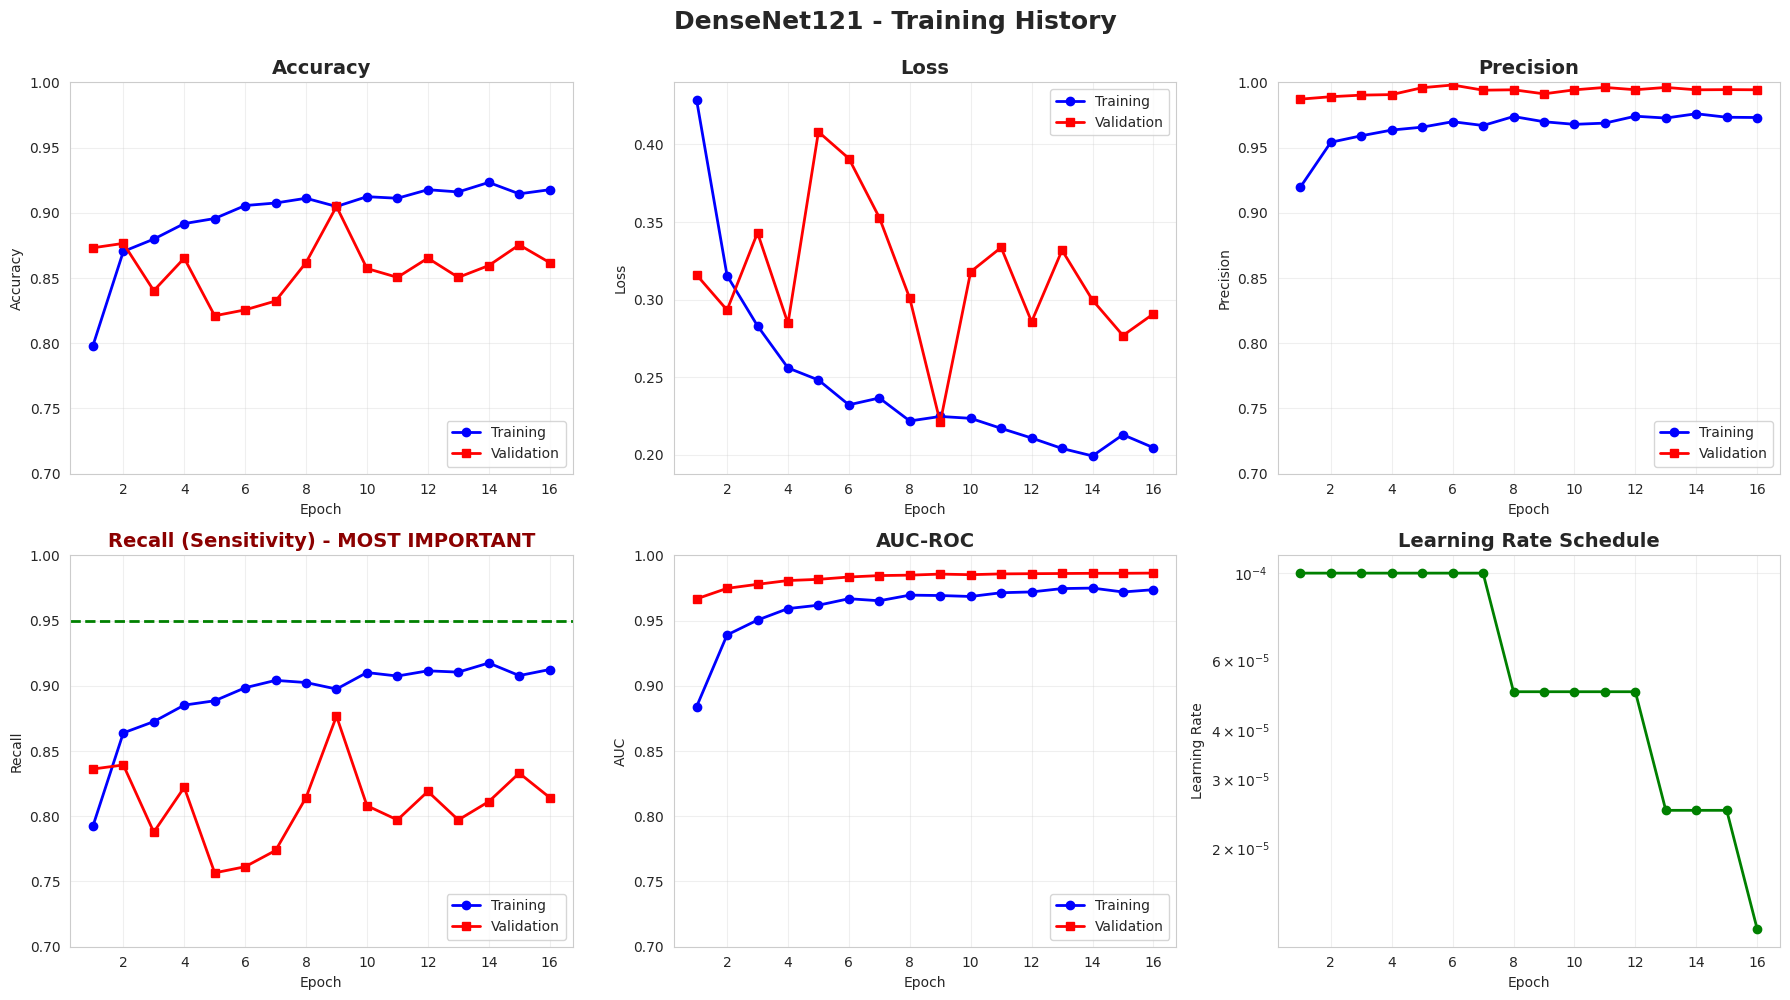

In [11]:
def plot_training_history(history, model_name='DenseNet121'):
    """
    Create comprehensive training history visualization
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name} - Training History', fontsize=18, fontweight='bold', y=0.995)

    epochs = range(1, len(history.history['accuracy']) + 1)

    # 1. Accuracy
    axes[0, 0].plot(epochs, history.history['accuracy'], 'b-', linewidth=2, label='Training', marker='o')
    axes[0, 0].plot(epochs, history.history['val_accuracy'], 'r-', linewidth=2, label='Validation', marker='s')
    axes[0, 0].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0.7, 1.0])

    # 2. Loss
    axes[0, 1].plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Training', marker='o')
    axes[0, 1].plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation', marker='s')
    axes[0, 1].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Precision
    axes[0, 2].plot(epochs, history.history['precision'], 'b-', linewidth=2, label='Training', marker='o')
    axes[0, 2].plot(epochs, history.history['val_precision'], 'r-', linewidth=2, label='Validation', marker='s')
    axes[0, 2].set_title('Precision', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend(loc='lower right')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim([0.7, 1.0])

    # 4. Recall (Sensitivity)
    axes[1, 0].plot(epochs, history.history['recall'], 'b-', linewidth=2, label='Training', marker='o')
    axes[1, 0].plot(epochs, history.history['val_recall'], 'r-', linewidth=2, label='Validation', marker='s')
    axes[1, 0].set_title('Recall (Sensitivity) - MOST IMPORTANT', fontsize=14, fontweight='bold', color='darkred')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0.7, 1.0])
    axes[1, 0].axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='Target (95%)')

    # 5. AUC
    axes[1, 1].plot(epochs, history.history['auc'], 'b-', linewidth=2, label='Training', marker='o')
    axes[1, 1].plot(epochs, history.history['val_auc'], 'r-', linewidth=2, label='Validation', marker='s')
    axes[1, 1].set_title('AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend(loc='lower right')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0.7, 1.0])

    # 6. Learning Rate
    if 'learning_rate' in history.history:
        # Extract learning rate from history
        lr_values = history.history.get('lr', history.history.get('learning_rate', []))
        if lr_values:
            axes[1, 2].plot(epochs, lr_values, 'g-', linewidth=2, marker='o')
            axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Learning Rate')
            axes[1, 2].set_yscale('log')
            axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'Learning Rate\nNot Tracked',
                       ha='center', va='center', fontsize=14)
        axes[1, 2].axis('off')

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(RESULTS_DIR, f'{model_name}_training_history.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to: {save_path}")

    plt.show()

print("=" * 60)
print("PLOTTING TRAINING HISTORY")
print("=" * 60)

plot_training_history(history, 'DenseNet121')

In [12]:
print("=" * 60)
print("EVALUATING ON TEST SET")
print("=" * 60)

# Load the best model (from epoch 9 with lowest val_loss)
best_model_path = os.path.join(MODELS_DIR, 'densenet121_best_model.keras')
print(f"\nLoading best model from: {best_model_path}")

best_model = keras.models.load_model(best_model_path)
print("✓ Best model loaded successfully!")

# Reset test generator
test_generator.reset()

print("\n" + "=" * 60)
print("RUNNING PREDICTIONS ON TEST SET")
print("=" * 60)
print(f"Test samples: {test_generator.samples}")
print(f"Processing...")

# Get predictions (probabilities)
predictions_proba = best_model.predict(test_generator, verbose=1)
predictions_proba = predictions_proba.flatten()

# Get predicted classes (default threshold = 0.5)
predictions_classes = (predictions_proba > 0.5).astype(int)

# Get true labels
true_classes = test_generator.classes

print(f"\n✓ Predictions complete!")
print(f"   Prediction shape: {predictions_proba.shape}")
print(f"   True labels shape: {true_classes.shape}")

# Evaluate model metrics
print("\n" + "=" * 60)
print("CALCULATING METRICS")
print("=" * 60)

test_loss, test_accuracy, test_precision, test_recall, test_auc = best_model.evaluate(
    test_generator,
    verbose=0
)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predictions_classes)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
specificity = tn / (tn + fp)
sensitivity = test_recall  # Recall = Sensitivity = TPR
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# Calculate NPV and PPV
ppv = tp / (tp + fp)  # Positive Predictive Value = Precision
npv = tn / (tn + fn)  # Negative Predictive Value

print("\n" + "=" * 60)
print("📊 DENSENET121 - TEST SET RESULTS")
print("=" * 60)

print(f"\n🎯 PRIMARY METRICS:")
print(f"   Accuracy:           {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%) ⭐ CRITICAL")
print(f"   Specificity:        {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   Precision (PPV):    {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   F1-Score:           {f1_score:.4f}")
print(f"   AUC-ROC:            {test_auc:.4f}")

print(f"\n📈 CLINICAL METRICS:")
print(f"   Positive Predictive Value (PPV): {ppv:.4f} ({ppv*100:.2f}%)")
print(f"   Negative Predictive Value (NPV): {npv:.4f} ({npv*100:.2f}%)")

print(f"\n🔢 CONFUSION MATRIX:")
print(f"   True Negatives (TN):  {tn:4d} (Correctly identified NORMAL)")
print(f"   False Positives (FP): {fp:4d} (NORMAL wrongly flagged as PNEUMONIA)")
print(f"   False Negatives (FN): {fn:4d} (PNEUMONIA missed) ⚠️")
print(f"   True Positives (TP):  {tp:4d} (Correctly identified PNEUMONIA)")

print(f"\n📊 TOTAL TEST SAMPLES: {len(true_classes)}")
print(f"   NORMAL cases:     {np.sum(true_classes == 0)}")
print(f"   PNEUMONIA cases:  {np.sum(true_classes == 1)}")

print("\n" + "=" * 60)

# Interpretation
if sensitivity >= 0.95:
    print("✅ EXCELLENT: Sensitivity meets clinical target (≥95%)")
elif sensitivity >= 0.90:
    print("✓ GOOD: Sensitivity above 90% - acceptable for screening")
else:
    print("⚠️  Sensitivity below 90% - consider threshold adjustment")

if specificity >= 0.85:
    print("✅ Specificity meets target (≥85%)")
else:
    print("⚠️  Specificity could be improved")

print("=" * 60)

EVALUATING ON TEST SET

Loading best model from: /content/drive/MyDrive/Pneumonia_Project/Models/saved_models/densenet121_best_model.keras
✓ Best model loaded successfully!

RUNNING PREDICTIONS ON TEST SET
Test samples: 879
Processing...
28/28 ━━━━━━━━━━━━━━━━━━━━ 267s 9s/step

✓ Predictions complete!
   Prediction shape: (879,)
   True labels shape: (879,)

CALCULATING METRICS

📊 DENSENET121 - TEST SET RESULTS

🎯 PRIMARY METRICS:
   Accuracy:           0.9204 (92.04%)
   Sensitivity (Recall): 0.9002 (90.02%) ⭐ CRITICAL
   Specificity:        0.9748 (97.48%)
   Precision (PPV):    0.9897 (98.97%)
   F1-Score:           0.9428
   AUC-ROC:            0.9810

📈 CLINICAL METRICS:
   Positive Predictive Value (PPV): 0.9897 (98.97%)
   Negative Predictive Value (NPV): 0.7838 (78.38%)

🔢 CONFUSION MATRIX:
   True Negatives (TN):   232 (Correctly identified NORMAL)
   False Positives (FP):    6 (NORMAL wrongly flagged as PNEUMONIA)
   False Negatives (FN):   64 (PNEUMONIA missed) ⚠️
   True Po

CREATING CONFUSION MATRIX VISUALIZATION
✓ Confusion matrix saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results/DenseNet121_confusion_matrix.png


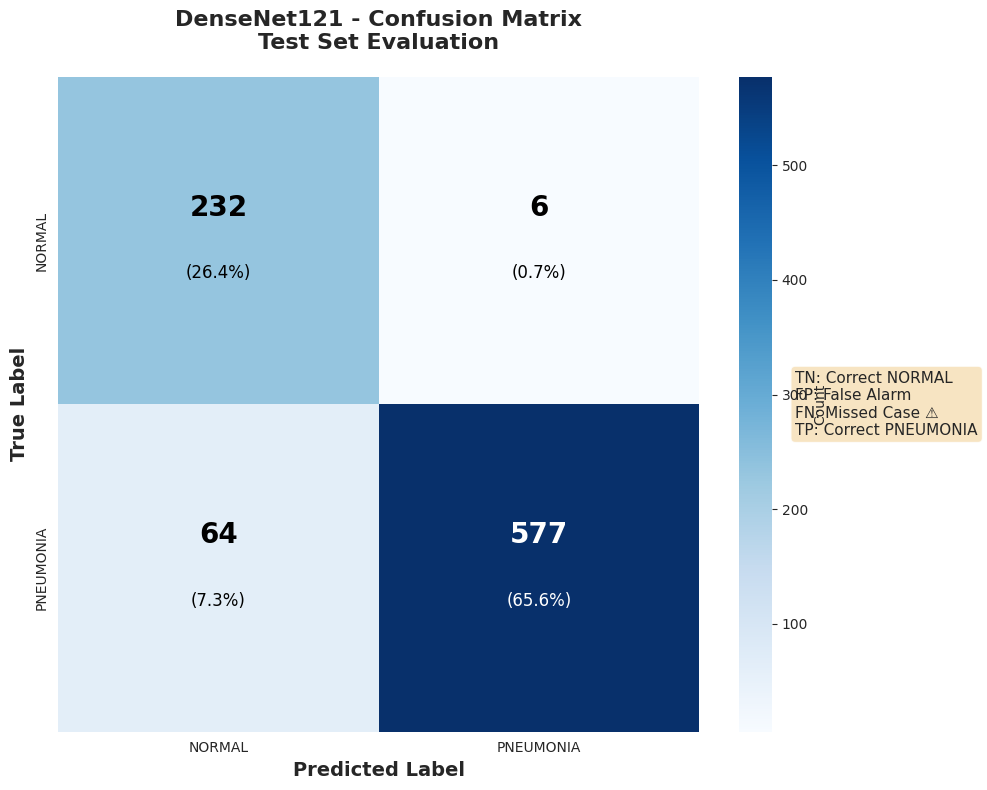

In [13]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name='DenseNet121'):
    """
    Plot confusion matrix with percentages and counts
    """
    cm = confusion_matrix(y_true, y_pred)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot heatmap
    sns.heatmap(
        cm,
        annot=False,  # We'll add custom annotations
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'},
        ax=ax
    )

    # Add custom annotations (count + percentage)
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            percentage = (count / total) * 100

            # Color text based on value
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'

            # Add text
            ax.text(j + 0.5, i + 0.4, f'{count}',
                   ha='center', va='center',
                   fontsize=20, fontweight='bold', color=text_color)
            ax.text(j + 0.5, i + 0.6, f'({percentage:.1f}%)',
                   ha='center', va='center',
                   fontsize=12, color=text_color)

    # Labels and title
    plt.title(f'{model_name} - Confusion Matrix\nTest Set Evaluation',
             fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')

    # Add interpretations as text boxes
    tn, fp, fn, tp = cm.ravel()

    textstr = f'TN: Correct NORMAL\nFP: False Alarm\nFN: Missed Case ⚠️\nTP: Correct PNEUMONIA'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(1.15, 0.5, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='center', bbox=props)

    plt.tight_layout()

    # Save
    save_path = os.path.join(RESULTS_DIR, f'{model_name}_confusion_matrix.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to: {save_path}")

    plt.show()

print("=" * 60)
print("CREATING CONFUSION MATRIX VISUALIZATION")
print("=" * 60)

plot_confusion_matrix(true_classes, predictions_classes, CONFIG['class_names'], 'DenseNet121')

CREATING ROC CURVE
✓ ROC curve saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results/DenseNet121_roc_curve.png


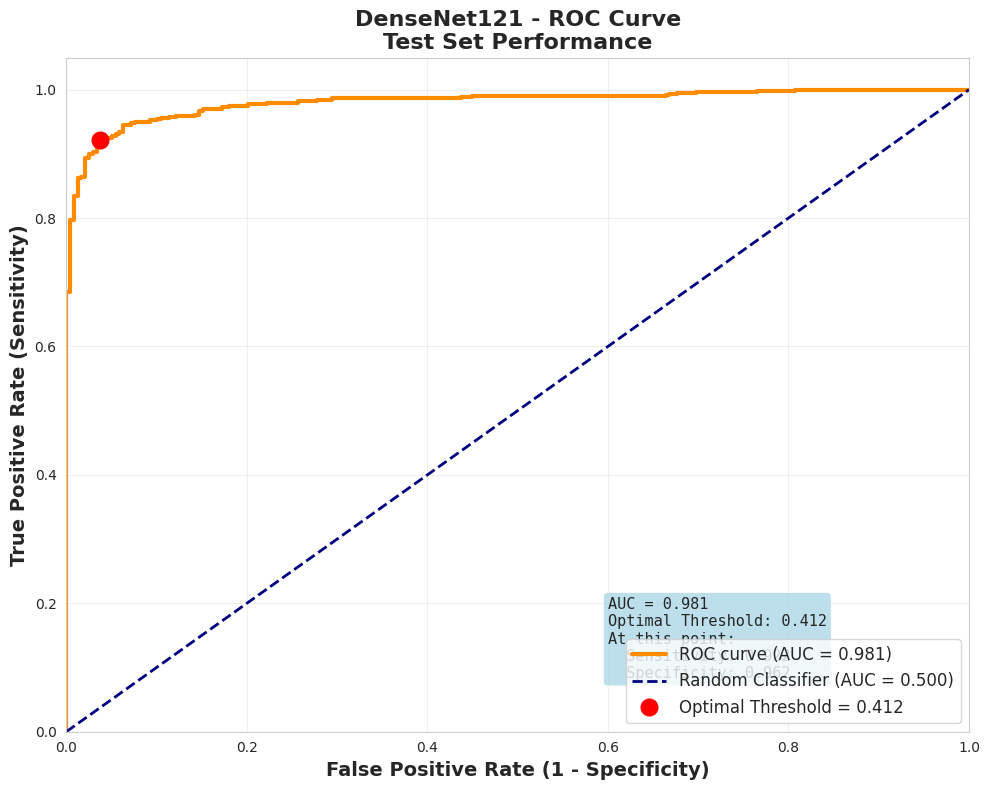


📊 ROC Analysis:
   AUC-ROC: 0.9810
   Optimal Threshold: 0.4121

💡 NOTE: Current threshold is 0.5
   Adjusting to 0.4121 may improve sensitivity!


In [14]:
def plot_roc_curve(y_true, y_pred_proba, model_name='DenseNet121'):
    """
    Plot ROC curve and find optimal threshold
    """
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold (Youden's Index)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    optimal_fpr = fpr[optimal_idx]

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=3,
            label=f'ROC curve (AUC = {roc_auc:.3f})')

    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
            label='Random Classifier (AUC = 0.500)')

    # Mark optimal threshold
    ax.plot(optimal_fpr, optimal_tpr, 'ro', markersize=12,
            label=f'Optimal Threshold = {optimal_threshold:.3f}')

    # Add grid
    ax.grid(True, alpha=0.3)

    # Labels and title
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold')
    ax.set_title(f'{model_name} - ROC Curve\nTest Set Performance',
                fontsize=16, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)

    # Add interpretation box
    textstr = f'AUC = {roc_auc:.3f}\n'
    textstr += f'Optimal Threshold: {optimal_threshold:.3f}\n'
    textstr += f'At this point:\n'
    textstr += f'  Sensitivity: {optimal_tpr:.3f}\n'
    textstr += f'  Specificity: {1-optimal_fpr:.3f}'

    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax.text(0.6, 0.2, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props, family='monospace')

    plt.tight_layout()

    # Save
    save_path = os.path.join(RESULTS_DIR, f'{model_name}_roc_curve.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ ROC curve saved to: {save_path}")

    plt.show()

    return optimal_threshold, roc_auc

print("=" * 60)
print("CREATING ROC CURVE")
print("=" * 60)

optimal_threshold, roc_auc_score = plot_roc_curve(true_classes, predictions_proba, 'DenseNet121')

print(f"\n📊 ROC Analysis:")
print(f"   AUC-ROC: {roc_auc_score:.4f}")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"\n💡 NOTE: Current threshold is 0.5")
print(f"   Adjusting to {optimal_threshold:.4f} may improve sensitivity!")

In [15]:
# Calculate training time in minutes
training_time_minutes = training_duration.total_seconds() / 60

# Create comprehensive results dictionary
results_dict = {
    'Model': 'DenseNet121',
    'Test_Accuracy': f'{test_accuracy:.4f}',
    'Test_Sensitivity': f'{sensitivity:.4f}',
    'Test_Specificity': f'{specificity:.4f}',
    'Test_Precision': f'{test_precision:.4f}',
    'Test_F1_Score': f'{f1_score:.4f}',
    'Test_AUC_ROC': f'{test_auc:.4f}',
    'Test_PPV': f'{ppv:.4f}',
    'Test_NPV': f'{npv:.4f}',
    'True_Negatives': tn,
    'False_Positives': fp,
    'False_Negatives': fn,
    'True_Positives': tp,
    'Total_Test_Samples': len(true_classes),
    'Training_Time_Minutes': f'{training_time_minutes:.2f}',
    'Epochs_Completed': len(history.history['loss']),
    'Best_Epoch': 9,  # From your training output
    'Total_Params': densenet121_model.count_params(),
    'Optimal_Threshold': f'{optimal_threshold:.4f}',
    'Image_Size': CONFIG['img_size'],
    'Batch_Size': CONFIG['batch_size'],
    'Learning_Rate': CONFIG['learning_rate'],
    'Date_Trained': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Create DataFrame
df_results = pd.DataFrame([results_dict])

# Save to CSV
results_csv_path = os.path.join(RESULTS_DIR, 'densenet121_complete_results.csv')
df_results.to_csv(results_csv_path, index=False)

print("=" * 60)
print("SAVING COMPLETE RESULTS")
print("=" * 60)
print(f"\n✓ Results saved to: {results_csv_path}")

# Display results table
print("\n📊 COMPLETE RESULTS TABLE:")
print("=" * 60)
print(df_results.T.to_string())
print("=" * 60)

# Save detailed report as text file
report_path = os.path.join(RESULTS_DIR, 'densenet121_evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("DENSENET121 PNEUMONIA DETECTION - EVALUATION REPORT\n")
    f.write("=" * 70 + "\n\n")

    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: DenseNet121\n")
    f.write(f"Dataset: Kaggle Pediatric Chest X-Ray Pneumonia\n\n")

    f.write("TRAINING SUMMARY:\n")
    f.write("-" * 70 + "\n")
    f.write(f"Training Time: {training_time_minutes:.2f} minutes\n")
    f.write(f"Epochs Completed: {len(history.history['loss'])}\n")
    f.write(f"Best Epoch: 9 (based on validation loss)\n")
    f.write(f"Early Stopping: Yes (patience = 7)\n\n")

    f.write("TEST SET PERFORMANCE:\n")
    f.write("-" * 70 + "\n")
    f.write(f"Total Samples: {len(true_classes)}\n")
    f.write(f"  NORMAL: {np.sum(true_classes == 0)}\n")
    f.write(f"  PNEUMONIA: {np.sum(true_classes == 1)}\n\n")

    f.write(f"Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")
    f.write(f"Sensitivity:  {sensitivity:.4f} ({sensitivity*100:.2f}%) ⭐\n")
    f.write(f"Specificity:  {specificity:.4f} ({specificity*100:.2f}%)\n")
    f.write(f"Precision:    {test_precision:.4f} ({test_precision*100:.2f}%)\n")
    f.write(f"F1-Score:     {f1_score:.4f}\n")
    f.write(f"AUC-ROC:      {test_auc:.4f}\n\n")

    f.write("CONFUSION MATRIX:\n")
    f.write("-" * 70 + "\n")
    f.write(f"True Negatives:  {tn:4d}\n")
    f.write(f"False Positives: {fp:4d}\n")
    f.write(f"False Negatives: {fn:4d}\n")
    f.write(f"True Positives:  {tp:4d}\n\n")

    f.write("CLINICAL INTERPRETATION:\n")
    f.write("-" * 70 + "\n")
    if sensitivity >= 0.95:
        f.write("✅ Sensitivity meets clinical target (≥95%)\n")
    else:
        f.write(f"⚠️  Sensitivity ({sensitivity:.2%}) below 95% target\n")

    if specificity >= 0.85:
        f.write("✅ Specificity meets target (≥85%)\n")
    else:
        f.write(f"⚠️  Specificity ({specificity:.2%}) below 85% target\n")

    f.write("\n" + "=" * 70 + "\n")

print(f"\n✓ Detailed report saved to: {report_path}")

print("\n" + "=" * 60)
print("✅ ALL EVALUATIONS COMPLETE!")
print("=" * 60)
print("\n📁 Generated Files:")
print(f"   1. Best model: {best_model_path}")
print(f"   2. Training history plot: {RESULTS_DIR}/DenseNet121_training_history.png")
print(f"   3. Confusion matrix: {RESULTS_DIR}/DenseNet121_confusion_matrix.png")
print(f"   4. ROC curve: {RESULTS_DIR}/DenseNet121_roc_curve.png")
print(f"   5. Results CSV: {results_csv_path}")
print(f"   6. Evaluation report: {report_path}")

SAVING COMPLETE RESULTS

✓ Results saved to: /content/drive/MyDrive/Pneumonia_Project/Models/results/densenet121_complete_results.csv

📊 COMPLETE RESULTS TABLE:
                                         0
Model                          DenseNet121
Test_Accuracy                       0.9204
Test_Sensitivity                    0.9002
Test_Specificity                    0.9748
Test_Precision                      0.9897
Test_F1_Score                       0.9428
Test_AUC_ROC                        0.9810
Test_PPV                            0.9897
Test_NPV                            0.7838
True_Negatives                         232
False_Positives                          6
False_Negatives                         64
True_Positives                         577
Total_Test_Samples                     879
Training_Time_Minutes                57.97
Epochs_Completed                        16
Best_Epoch                               9
Total_Params                       7562817
Optimal_Threshold     